# Objective
The goal is to build a machine learning model that predicts which Tweets are about real diasters and which one's aren't. 

# About the Data
This dataset was created by the company figure-eight and originally shared on their [Data For Everyone](https://appen.com/pre-labeled-datasets/) website. It contains 10,000 tweets that were hand classified. 

### Import libraries

In [98]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from wordcloud import STOPWORDS
import string
import re
import pandas as pd
import transformers
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk import FreqDist, bigrams
from nltk.tokenize import word_tokenize, sent_tokenize, TweetTokenizer
from transformers import TFAutoModel, AutoTokenizer
from datasets import Dataset, DatasetDict
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, Callback
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from sklearn.model_selection import KFold
from kerastuner.tuners import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters

### Train Dataset

In [99]:
train_df = pd.read_csv('../input/nlp-getting-started/train.csv', dtype={'id': np.int16, 'target': np.int8})
train_df.head(10)


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
5,8,NaN,NaN,#RockyFire Update => California Hwy. 20 closed...,1
6,10,NaN,NaN,#flood #disaster Heavy rain causes flash flood...,1
7,13,NaN,NaN,I'm on top of the hill and I can see a fire in...,1
8,14,NaN,NaN,There's an emergency evacuation happening now ...,1
9,15,NaN,NaN,I'm afraid that the tornado is coming to our a...,1


In [100]:
train_df.shape

(7613, 5)

# Exploratory Data Analysis

Text(0, 0.5, '# of Missing Values')

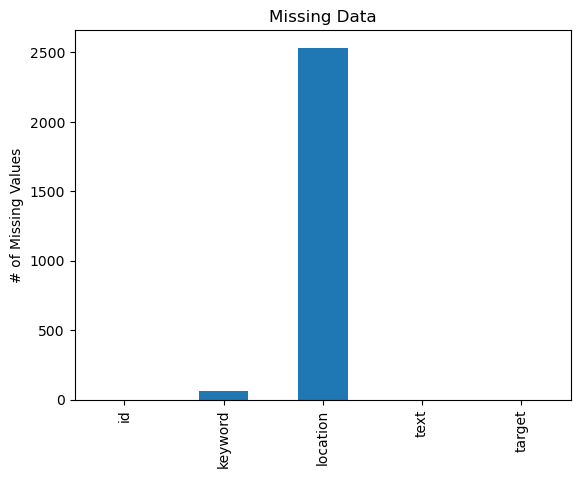

In [101]:
train_df.isna().sum().plot.bar()
plt.title('Missing Data')
plt.ylabel('# of Missing Values')

It appears that our `location` colunm is missing about ~28% of its values. Futher analysis must be done to determine if we should drop.

In [102]:
train_df.location.unique()


array([nan, 'Birmingham', 'Est. September 2012 - Bristol', ...,
       'Vancouver, Canada', 'London ', 'Lincoln'], dtype=object)

Understanding what type of values each column has will make it easier to drop. In our case it appears that the location column might hurt our accuracy instead of helping. 

In [103]:
train_df.keyword.unique()

array([nan, 'ablaze', 'accident', 'aftershock', 'airplane%20accident',
       'ambulance', 'annihilated', 'annihilation', 'apocalypse',
       'armageddon', 'army', 'arson', 'arsonist', 'attack', 'attacked',
       'avalanche', 'battle', 'bioterror', 'bioterrorism', 'blaze',
       'blazing', 'bleeding', 'blew%20up', 'blight', 'blizzard', 'blood',
       'bloody', 'blown%20up', 'body%20bag', 'body%20bagging',
       'body%20bags', 'bomb', 'bombed', 'bombing', 'bridge%20collapse',
       'buildings%20burning', 'buildings%20on%20fire', 'burned',
       'burning', 'burning%20buildings', 'bush%20fires', 'casualties',
       'casualty', 'catastrophe', 'catastrophic', 'chemical%20emergency',
       'cliff%20fall', 'collapse', 'collapsed', 'collide', 'collided',
       'collision', 'crash', 'crashed', 'crush', 'crushed', 'curfew',
       'cyclone', 'damage', 'danger', 'dead', 'death', 'deaths', 'debris',
       'deluge', 'deluged', 'demolish', 'demolished', 'demolition',
       'derail', 'der

Our `keyword` column has some missing data but overall it shows positive signs of useful data. 

In [104]:
train_df.target.unique()

array([1, 0], dtype=int8)

As expected the `target` column should only have values of `1` and `0`.

In [105]:
train_df.duplicated('text').sum()

110

Our `text` column has 110 duplicate tweets.

In [106]:
train_df.duplicated(['text', 'target']).sum()

92

In [107]:
train_df = train_df.drop_duplicates(["text", "target"])


we have 92 rows with duplicated text and target columns

(array([0, 1]), [Text(0, 0, '0'), Text(1, 0, '1')])

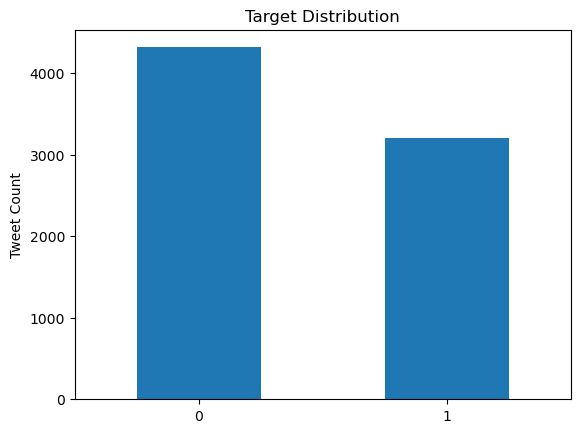

In [108]:
train_df.target.value_counts().plot(kind='bar')
plt.title("Target Distribution")
plt.ylabel("Tweet Count")
plt.xticks(rotation=360)

In [109]:
num_samples = len(train_df)

### Test Dataset

In [110]:
test_df = pd.read_csv('../input/nlp-getting-started/test.csv', dtype={'id': np.int16})
test_df.head()


,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [111]:
test_df.shape

(3263, 4)

In [112]:
def plot_word_frequency(dataframe, column_name, top_n=25):
    """
    Plots the word frequency of a column in a dataframe.

    Args:
        dataframe (pandas.DataFrame): The dataframe containing the text data.
        column_name (str): The name of the column in the dataframe to analyze.
        top_n (int, optional): The number of top words to plot. Defaults to 25.
    """
    # Tokenize the text in the specified column
    tokens = word_tokenize(' '.join(dataframe[column_name]))
    
    # Create a frequency distribution of words
    fdist = FreqDist(tokens)
    
    # Get the top n most frequent words
    top_words = fdist.most_common(top_n)
    
    # Extract the words and their frequencies
    words = [word[0] for word in top_words]
    frequencies = [freq[1] for freq in top_words]
    
    # Plot the bar graph
    plt.figure(figsize=(12, 6))
    plt.bar(words, frequencies)
    plt.title(f'Top {top_n} Most Frequent Words in {column_name}')
    plt.xlabel('Words')
    plt.ylabel('Frequency')
    plt.xticks(rotation=90)
    plt.show()

## Word Frequency Before Cleaning

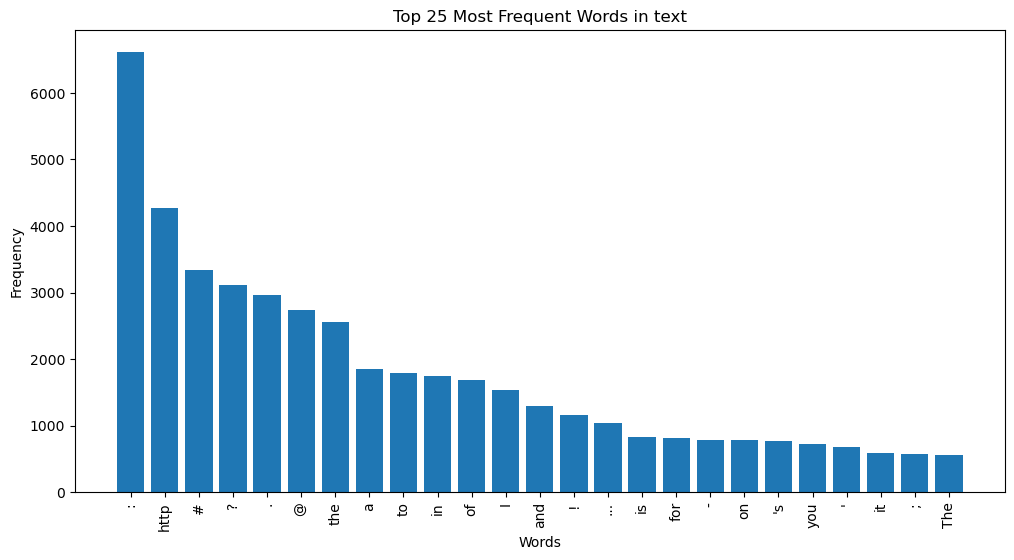

In [113]:
plot_word_frequency(train_df, 'text', top_n=25)

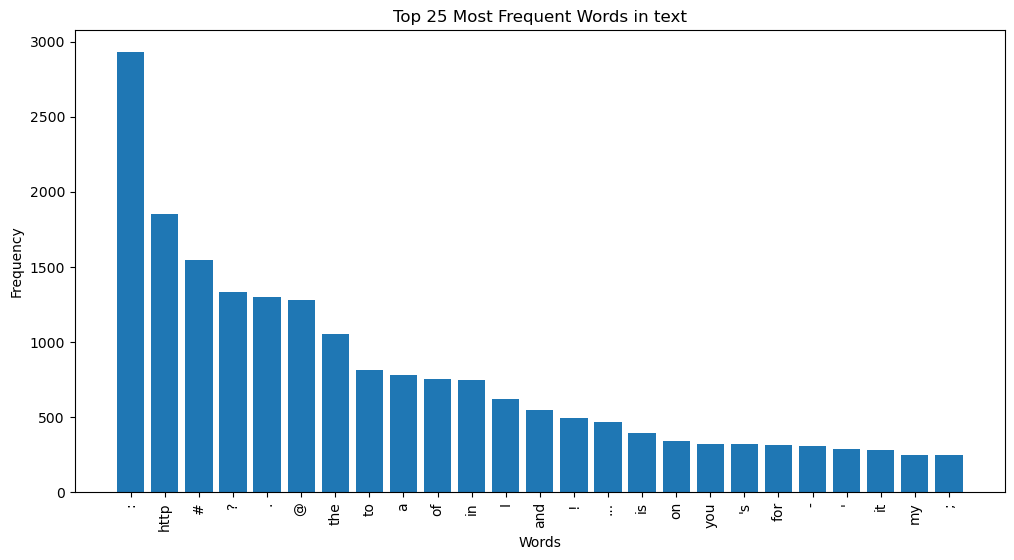

In [114]:
plot_word_frequency(test_df, 'text', top_n=25)

### Summary:
##### Train Dataset
- The training contains 5 columns and 7,613 tweets.
- There was no duplicates
- Our columns are the appropriate data type
- `location` column is missing about 28% of its data.
- There was 92 duplicate observations which we dropped
- As you can see from the frequency graph a significant amount of our tokens are special characters. These types of characters do not added significant value to our model. 

##### Test Dataset
- The testing dataset contains all the columns as the training set except for the target column.
- We have 4 columns and 3,263 tweets
- There is no duplicates 

Overall, it appears that our dataset is pretty small with only about 10k tweets. 7k off them are for the training dataset and the remainding 3k are allocated to our testing model. It appears that our `text` column contains a lot of special characters which might make it difficult for our model to learn. The goal is to correctly classify our tweets so we will need to drop the `location` column and omit some of the special characters. 

# Cleaning & Preprocessing

In [115]:
# word_count
train_df['word_count'] = train_df['text'].apply(lambda x: len(str(x).split()))
test_df['word_count'] = test_df['text'].apply(lambda x: len(str(x).split()))

# unique_word_count
train_df['unique_word_count'] = train_df['text'].apply(
    lambda x: len(set(str(x).split())))
test_df['unique_word_count'] = test_df['text'].apply(
    lambda x: len(set(str(x).split())))

# stop_word_count
train_df['stop_word_count'] = train_df['text'].apply(
    lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))
test_df['stop_word_count'] = test_df['text'].apply(
    lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))

# url_count
train_df['url_count'] = train_df['text'].apply(lambda x: len(
    [w for w in str(x).lower().split() if 'http' in w or 'https' in w]))
test_df['url_count'] = test_df['text'].apply(lambda x: len(
    [w for w in str(x).lower().split() if 'http' in w or 'https' in w]))

# mean_word_length
train_df['mean_word_length'] = train_df['text'].apply(
    lambda x: np.mean([len(w) for w in str(x).split()]))
test_df['mean_word_length'] = test_df['text'].apply(
    lambda x: np.mean([len(w) for w in str(x).split()]))

# char_count
train_df['char_count'] = train_df['text'].apply(lambda x: len(str(x)))
test_df['char_count'] = test_df['text'].apply(lambda x: len(str(x)))

# punctuation_count
train_df['punctuation_count'] = train_df['text'].apply(
    lambda x: len([c for c in str(x) if c in string.punctuation]))
test_df['punctuation_count'] = test_df['text'].apply(
    lambda x: len([c for c in str(x) if c in string.punctuation]))

# hashtag_count
train_df['hashtag_count'] = train_df['text'].apply(
    lambda x: len([c for c in str(x) if c == '#']))
test_df['hashtag_count'] = test_df['text'].apply(
    lambda x: len([c for c in str(x) if c == '#']))

# mention_count
train_df['mention_count'] = train_df['text'].apply(
    lambda x: len([c for c in str(x) if c == '@']))
test_df['mention_count'] = test_df['text'].apply(
    lambda x: len([c for c in str(x) if c == '@']))



In [116]:
train_df

,id,keyword,location,text,target,word_count,unique_word_count,stop_word_count,url_count,mean_word_length,char_count,punctuation_count,hashtag_count,mention_count
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,13,13,6,0,4.384615,69,1,1,0
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,7,7,0,0,4.571429,38,1,0,0
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,22,20,11,0,5.090909,133,3,0,0
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,8,8,1,0,7.125000,65,2,1,0
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,16,15,7,0,4.500000,88,2,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7604,10863,NaN,NaN,#WorldNews Fallen powerlines on G:link tram: U...,1,19,19,6,1,6.210526,136,12,1,0
7605,10864,NaN,NaN,on the flip side I'm at Walmart and there is a...,1,26,25,17,0,3.423077,114,1,0,0
7606,10866,NaN,NaN,Suicide bomber kills 15 in Saudi security site...,1,20,18,1,1,5.100000,121,11,0,0
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1,11,11,2,1,6.636364,83,5,0,0


In [117]:

def clean(tweet):

    # Special characters
    tweet = re.sub(r"\x89Û_", "", tweet)
    tweet = re.sub(r"\x89ÛÒ", "", tweet)
    tweet = re.sub(r"\x89ÛÓ", "", tweet)
    tweet = re.sub(r"\x89ÛÏWhen", "When", tweet)
    tweet = re.sub(r"\x89ÛÏ", "", tweet)
    tweet = re.sub(r"China\x89Ûªs", "China's", tweet)
    tweet = re.sub(r"let\x89Ûªs", "let's", tweet)
    tweet = re.sub(r"\x89Û÷", "", tweet)
    tweet = re.sub(r"\x89Ûª", "", tweet)
    tweet = re.sub(r"\x89Û\x9d", "", tweet)
    tweet = re.sub(r"å_", "", tweet)
    tweet = re.sub(r"\x89Û¢", "", tweet)
    tweet = re.sub(r"\x89Û¢åÊ", "", tweet)
    tweet = re.sub(r"fromåÊwounds", "from wounds", tweet)
    tweet = re.sub(r"åÊ", "", tweet)
    tweet = re.sub(r"åÈ", "", tweet)
    tweet = re.sub(r"JapÌ_n", "Japan", tweet)
    tweet = re.sub(r"Ì©", "e", tweet)
    tweet = re.sub(r"å¨", "", tweet)
    tweet = re.sub(r"SuruÌ¤", "Suruc", tweet)
    tweet = re.sub(r"åÇ", "", tweet)
    tweet = re.sub(r"å£3million", "3 million", tweet)
    tweet = re.sub(r"åÀ", "", tweet)

    # Contractions
    tweet = re.sub(r"he's", "he is", tweet)
    tweet = re.sub(r"there's", "there is", tweet)
    tweet = re.sub(r"We're", "We are", tweet)
    tweet = re.sub(r"That's", "That is", tweet)
    tweet = re.sub(r"won't", "will not", tweet)
    tweet = re.sub(r"they're", "they are", tweet)
    tweet = re.sub(r"Can't", "Cannot", tweet)
    tweet = re.sub(r"wasn't", "was not", tweet)
    tweet = re.sub(r"don\x89Ûªt", "do not", tweet)
    tweet = re.sub(r"aren't", "are not", tweet)
    tweet = re.sub(r"isn't", "is not", tweet)
    tweet = re.sub(r"What's", "What is", tweet)
    tweet = re.sub(r"haven't", "have not", tweet)
    tweet = re.sub(r"hasn't", "has not", tweet)
    tweet = re.sub(r"There's", "There is", tweet)
    tweet = re.sub(r"He's", "He is", tweet)
    tweet = re.sub(r"It's", "It is", tweet)
    tweet = re.sub(r"You're", "You are", tweet)
    tweet = re.sub(r"I'M", "I am", tweet)
    tweet = re.sub(r"shouldn't", "should not", tweet)
    tweet = re.sub(r"wouldn't", "would not", tweet)
    tweet = re.sub(r"i'm", "I am", tweet)
    tweet = re.sub(r"I\x89Ûªm", "I am", tweet)
    tweet = re.sub(r"I'm", "I am", tweet)
    tweet = re.sub(r"Isn't", "is not", tweet)
    tweet = re.sub(r"Here's", "Here is", tweet)
    tweet = re.sub(r"you've", "you have", tweet)
    tweet = re.sub(r"you\x89Ûªve", "you have", tweet)
    tweet = re.sub(r"we're", "we are", tweet)
    tweet = re.sub(r"what's", "what is", tweet)
    tweet = re.sub(r"couldn't", "could not", tweet)
    tweet = re.sub(r"we've", "we have", tweet)
    tweet = re.sub(r"it\x89Ûªs", "it is", tweet)
    tweet = re.sub(r"doesn\x89Ûªt", "does not", tweet)
    tweet = re.sub(r"It\x89Ûªs", "It is", tweet)
    tweet = re.sub(r"Here\x89Ûªs", "Here is", tweet)
    tweet = re.sub(r"who's", "who is", tweet)
    tweet = re.sub(r"I\x89Ûªve", "I have", tweet)
    tweet = re.sub(r"y'all", "you all", tweet)
    tweet = re.sub(r"can\x89Ûªt", "cannot", tweet)
    tweet = re.sub(r"would've", "would have", tweet)
    tweet = re.sub(r"it'll", "it will", tweet)
    tweet = re.sub(r"we'll", "we will", tweet)
    tweet = re.sub(r"wouldn\x89Ûªt", "would not", tweet)
    tweet = re.sub(r"We've", "We have", tweet)
    tweet = re.sub(r"he'll", "he will", tweet)
    tweet = re.sub(r"Y'all", "You all", tweet)
    tweet = re.sub(r"Weren't", "Were not", tweet)
    tweet = re.sub(r"Didn't", "Did not", tweet)
    tweet = re.sub(r"they'll", "they will", tweet)
    tweet = re.sub(r"they'd", "they would", tweet)
    tweet = re.sub(r"DON'T", "DO NOT", tweet)
    tweet = re.sub(r"That\x89Ûªs", "That is", tweet)
    tweet = re.sub(r"they've", "they have", tweet)
    tweet = re.sub(r"i'd", "I would", tweet)
    tweet = re.sub(r"should've", "should have", tweet)
    tweet = re.sub(r"You\x89Ûªre", "You are", tweet)
    tweet = re.sub(r"where's", "where is", tweet)
    tweet = re.sub(r"Don\x89Ûªt", "Do not", tweet)
    tweet = re.sub(r"we'd", "we would", tweet)
    tweet = re.sub(r"i'll", "I will", tweet)
    tweet = re.sub(r"weren't", "were not", tweet)
    tweet = re.sub(r"They're", "They are", tweet)
    tweet = re.sub(r"Can\x89Ûªt", "Cannot", tweet)
    tweet = re.sub(r"you\x89Ûªll", "you will", tweet)
    tweet = re.sub(r"I\x89Ûªd", "I would", tweet)
    tweet = re.sub(r"let's", "let us", tweet)
    tweet = re.sub(r"it's", "it is", tweet)
    tweet = re.sub(r"can't", "cannot", tweet)
    tweet = re.sub(r"don't", "do not", tweet)
    tweet = re.sub(r"you're", "you are", tweet)
    tweet = re.sub(r"i've", "I have", tweet)
    tweet = re.sub(r"that's", "that is", tweet)
    tweet = re.sub(r"i'll", "I will", tweet)
    tweet = re.sub(r"doesn't", "does not", tweet)
    tweet = re.sub(r"i'd", "I would", tweet)
    tweet = re.sub(r"didn't", "did not", tweet)
    tweet = re.sub(r"ain't", "am not", tweet)
    tweet = re.sub(r"you'll", "you will", tweet)
    tweet = re.sub(r"I've", "I have", tweet)
    tweet = re.sub(r"Don't", "do not", tweet)
    tweet = re.sub(r"I'll", "I will", tweet)
    tweet = re.sub(r"I'd", "I would", tweet)
    tweet = re.sub(r"Let's", "Let us", tweet)
    tweet = re.sub(r"you'd", "You would", tweet)
    tweet = re.sub(r"It's", "It is", tweet)
    tweet = re.sub(r"Ain't", "am not", tweet)
    tweet = re.sub(r"Haven't", "Have not", tweet)
    tweet = re.sub(r"Could've", "Could have", tweet)
    tweet = re.sub(r"youve", "you have", tweet)
    tweet = re.sub(r"donå«t", "do not", tweet)

    # Character entity references
    tweet = re.sub(r"&gt;", ">", tweet)
    tweet = re.sub(r"&lt;", "<", tweet)
    tweet = re.sub(r"&amp;", "&", tweet)

    # Typos, slang and informal abbreviations
    tweet = re.sub(r"w/e", "whatever", tweet)
    tweet = re.sub(r"w/", "with", tweet)
    tweet = re.sub(r"USAgov", "USA government", tweet)
    tweet = re.sub(r"recentlu", "recently", tweet)
    tweet = re.sub(r"Ph0tos", "Photos", tweet)
    tweet = re.sub(r"amirite", "am I right", tweet)
    tweet = re.sub(r"exp0sed", "exposed", tweet)
    tweet = re.sub(r"<3", "love", tweet)
    tweet = re.sub(r"amageddon", "armageddon", tweet)
    tweet = re.sub(r"Trfc", "Traffic", tweet)
    tweet = re.sub(r"8/5/2015", "2015-08-05", tweet)
    tweet = re.sub(r"WindStorm", "Wind Storm", tweet)
    tweet = re.sub(r"8/6/2015", "2015-08-06", tweet)
    tweet = re.sub(r"10:38PM", "10:38 PM", tweet)
    tweet = re.sub(r"10:30pm", "10:30 PM", tweet)
    tweet = re.sub(r"16yr", "16 year", tweet)
    tweet = re.sub(r"lmao", "laughing my ass off", tweet)
    tweet = re.sub(r"TRAUMATISED", "traumatized", tweet)

    # Hashtags and usernames
    tweet = re.sub(r"IranDeal", "Iran Deal", tweet)
    tweet = re.sub(r"ArianaGrande", "Ariana Grande", tweet)
    tweet = re.sub(r"camilacabello97", "camila cabello", tweet)
    tweet = re.sub(r"RondaRousey", "Ronda Rousey", tweet)
    tweet = re.sub(r"MTVHottest", "MTV Hottest", tweet)
    tweet = re.sub(r"TrapMusic", "Trap Music", tweet)
    tweet = re.sub(r"ProphetMuhammad", "Prophet Muhammad", tweet)
    tweet = re.sub(r"PantherAttack", "Panther Attack", tweet)
    tweet = re.sub(r"StrategicPatience", "Strategic Patience", tweet)
    tweet = re.sub(r"socialnews", "social news", tweet)
    tweet = re.sub(r"NASAHurricane", "NASA Hurricane", tweet)
    tweet = re.sub(r"onlinecommunities", "online communities", tweet)
    tweet = re.sub(r"humanconsumption", "human consumption", tweet)
    tweet = re.sub(r"Typhoon-Devastated", "Typhoon Devastated", tweet)
    tweet = re.sub(r"Meat-Loving", "Meat Loving", tweet)
    tweet = re.sub(r"facialabuse", "facial abuse", tweet)
    tweet = re.sub(r"LakeCounty", "Lake County", tweet)
    tweet = re.sub(r"BeingAuthor", "Being Author", tweet)
    tweet = re.sub(r"withheavenly", "with heavenly", tweet)
    tweet = re.sub(r"thankU", "thank you", tweet)
    tweet = re.sub(r"iTunesMusic", "iTunes Music", tweet)
    tweet = re.sub(r"OffensiveContent", "Offensive Content", tweet)
    tweet = re.sub(r"WorstSummerJob", "Worst Summer Job", tweet)
    tweet = re.sub(r"HarryBeCareful", "Harry Be Careful", tweet)
    tweet = re.sub(r"NASASolarSystem", "NASA Solar System", tweet)
    tweet = re.sub(r"animalrescue", "animal rescue", tweet)
    tweet = re.sub(r"KurtSchlichter", "Kurt Schlichter", tweet)
    tweet = re.sub(r"aRmageddon", "armageddon", tweet)
    tweet = re.sub(r"Throwingknifes", "Throwing knives", tweet)
    tweet = re.sub(r"GodsLove", "God's Love", tweet)
    tweet = re.sub(r"bookboost", "book boost", tweet)
    tweet = re.sub(r"ibooklove", "I book love", tweet)
    tweet = re.sub(r"NestleIndia", "Nestle India", tweet)
    tweet = re.sub(r"realDonaldTrump", "Donald Trump", tweet)
    tweet = re.sub(r"DavidVonderhaar", "David Vonderhaar", tweet)
    tweet = re.sub(r"CecilTheLion", "Cecil The Lion", tweet)
    tweet = re.sub(r"weathernetwork", "weather network", tweet)
    tweet = re.sub(r"withBioterrorism&use", "with Bioterrorism & use", tweet)
    tweet = re.sub(r"Hostage&2", "Hostage & 2", tweet)
    tweet = re.sub(r"GOPDebate", "GOP Debate", tweet)
    tweet = re.sub(r"RickPerry", "Rick Perry", tweet)
    tweet = re.sub(r"frontpage", "front page", tweet)
    tweet = re.sub(r"NewsInTweets", "News In Tweets", tweet)
    tweet = re.sub(r"ViralSpell", "Viral Spell", tweet)
    tweet = re.sub(r"til_now", "until now", tweet)
    tweet = re.sub(r"volcanoinRussia", "volcano in Russia", tweet)
    tweet = re.sub(r"ZippedNews", "Zipped News", tweet)
    tweet = re.sub(r"MicheleBachman", "Michele Bachman", tweet)
    tweet = re.sub(r"53inch", "53 inch", tweet)
    tweet = re.sub(r"KerrickTrial", "Kerrick Trial", tweet)
    tweet = re.sub(r"abstorm", "Alberta Storm", tweet)
    tweet = re.sub(r"Beyhive", "Beyonce hive", tweet)
    tweet = re.sub(r"IDFire", "Idaho Fire", tweet)
    tweet = re.sub(r"DETECTADO", "Detected", tweet)
    tweet = re.sub(r"RockyFire", "Rocky Fire", tweet)
    tweet = re.sub(r"Listen/Buy", "Listen / Buy", tweet)
    tweet = re.sub(r"NickCannon", "Nick Cannon", tweet)
    tweet = re.sub(r"FaroeIslands", "Faroe Islands", tweet)
    tweet = re.sub(r"yycstorm", "Calgary Storm", tweet)
    tweet = re.sub(r"IDPs:", "Internally Displaced People :", tweet)
    tweet = re.sub(r"ArtistsUnited", "Artists United", tweet)
    tweet = re.sub(r"ClaytonBryant", "Clayton Bryant", tweet)
    tweet = re.sub(r"jimmyfallon", "jimmy fallon", tweet)
    tweet = re.sub(r"justinbieber", "justin bieber", tweet)
    tweet = re.sub(r"UTC2015", "UTC 2015", tweet)
    tweet = re.sub(r"Time2015", "Time 2015", tweet)
    tweet = re.sub(r"djicemoon", "dj icemoon", tweet)
    tweet = re.sub(r"LivingSafely", "Living Safely", tweet)
    tweet = re.sub(r"FIFA16", "Fifa 2016", tweet)
    tweet = re.sub(r"thisiswhywecanthavenicethings",
                   "this is why we cannot have nice things", tweet)
    tweet = re.sub(r"bbcnews", "bbc news", tweet)
    tweet = re.sub(r"UndergroundRailraod", "Underground Railraod", tweet)
    tweet = re.sub(r"c4news", "c4 news", tweet)
    tweet = re.sub(r"OBLITERATION", "obliteration", tweet)
    tweet = re.sub(r"MUDSLIDE", "mudslide", tweet)
    tweet = re.sub(r"NoSurrender", "No Surrender", tweet)
    tweet = re.sub(r"NotExplained", "Not Explained", tweet)
    tweet = re.sub(r"greatbritishbakeoff", "great british bake off", tweet)
    tweet = re.sub(r"LondonFire", "London Fire", tweet)
    tweet = re.sub(r"KOTAWeather", "KOTA Weather", tweet)
    tweet = re.sub(r"LuchaUnderground", "Lucha Underground", tweet)
    tweet = re.sub(r"KOIN6News", "KOIN 6 News", tweet)
    tweet = re.sub(r"LiveOnK2", "Live On K2", tweet)
    tweet = re.sub(r"9NewsGoldCoast", "9 News Gold Coast", tweet)
    tweet = re.sub(r"nikeplus", "nike plus", tweet)
    tweet = re.sub(r"david_cameron", "David Cameron", tweet)
    tweet = re.sub(r"peterjukes", "Peter Jukes", tweet)
    tweet = re.sub(r"JamesMelville", "James Melville", tweet)
    tweet = re.sub(r"megynkelly", "Megyn Kelly", tweet)
    tweet = re.sub(r"cnewslive", "C News Live", tweet)
    tweet = re.sub(r"JamaicaObserver", "Jamaica Observer", tweet)
    tweet = re.sub(r"TweetLikeItsSeptember11th2001",
                   "Tweet like it is september 11th 2001", tweet)
    tweet = re.sub(r"cbplawyers", "cbp lawyers", tweet)
    tweet = re.sub(r"fewmoretweets", "few more tweets", tweet)
    tweet = re.sub(r"BlackLivesMatter", "Black Lives Matter", tweet)
    tweet = re.sub(r"cjoyner", "Chris Joyner", tweet)
    tweet = re.sub(r"ENGvAUS", "England vs Australia", tweet)
    tweet = re.sub(r"ScottWalker", "Scott Walker", tweet)
    tweet = re.sub(r"MikeParrActor", "Michael Parr", tweet)
    tweet = re.sub(r"4PlayThursdays", "Foreplay Thursdays", tweet)
    tweet = re.sub(r"TGF2015", "Tontitown Grape Festival", tweet)
    tweet = re.sub(r"realmandyrain", "Mandy Rain", tweet)
    tweet = re.sub(r"GraysonDolan", "Grayson Dolan", tweet)
    tweet = re.sub(r"ApolloBrown", "Apollo Brown", tweet)
    tweet = re.sub(r"saddlebrooke", "Saddlebrooke", tweet)
    tweet = re.sub(r"TontitownGrape", "Tontitown Grape", tweet)
    tweet = re.sub(r"AbbsWinston", "Abbs Winston", tweet)
    tweet = re.sub(r"ShaunKing", "Shaun King", tweet)
    tweet = re.sub(r"MeekMill", "Meek Mill", tweet)
    tweet = re.sub(r"TornadoGiveaway", "Tornado Giveaway", tweet)
    tweet = re.sub(r"GRupdates", "GR updates", tweet)
    tweet = re.sub(r"SouthDowns", "South Downs", tweet)
    tweet = re.sub(r"braininjury", "brain injury", tweet)
    tweet = re.sub(r"auspol", "Australian politics", tweet)
    tweet = re.sub(r"PlannedParenthood", "Planned Parenthood", tweet)
    tweet = re.sub(r"calgaryweather", "Calgary Weather", tweet)
    tweet = re.sub(r"weallheartonedirection",
                   "we all heart one direction", tweet)
    tweet = re.sub(r"edsheeran", "Ed Sheeran", tweet)
    tweet = re.sub(r"TrueHeroes", "True Heroes", tweet)
    tweet = re.sub(r"S3XLEAK", "sex leak", tweet)
    tweet = re.sub(r"ComplexMag", "Complex Magazine", tweet)
    tweet = re.sub(r"TheAdvocateMag", "The Advocate Magazine", tweet)
    tweet = re.sub(r"CityofCalgary", "City of Calgary", tweet)
    tweet = re.sub(r"EbolaOutbreak", "Ebola Outbreak", tweet)
    tweet = re.sub(r"SummerFate", "Summer Fate", tweet)
    tweet = re.sub(r"RAmag", "Royal Academy Magazine", tweet)
    tweet = re.sub(r"offers2go", "offers to go", tweet)
    tweet = re.sub(r"foodscare", "food scare", tweet)
    tweet = re.sub(r"MNPDNashville",
                   "Metropolitan Nashville Police Department", tweet)
    tweet = re.sub(r"TfLBusAlerts", "TfL Bus Alerts", tweet)
    tweet = re.sub(r"GamerGate", "Gamer Gate", tweet)
    tweet = re.sub(r"IHHen", "Humanitarian Relief", tweet)
    tweet = re.sub(r"spinningbot", "spinning bot", tweet)
    tweet = re.sub(r"ModiMinistry", "Modi Ministry", tweet)
    tweet = re.sub(r"TAXIWAYS", "taxi ways", tweet)
    tweet = re.sub(r"Calum5SOS", "Calum Hood", tweet)
    tweet = re.sub(r"po_st", "po.st", tweet)
    tweet = re.sub(r"scoopit", "scoop.it", tweet)
    tweet = re.sub(r"UltimaLucha", "Ultima Lucha", tweet)
    tweet = re.sub(r"JonathanFerrell", "Jonathan Ferrell", tweet)
    tweet = re.sub(r"aria_ahrary", "Aria Ahrary", tweet)
    tweet = re.sub(r"rapidcity", "Rapid City", tweet)
    tweet = re.sub(r"OutBid", "outbid", tweet)
    tweet = re.sub(r"lavenderpoetrycafe", "lavender poetry cafe", tweet)
    tweet = re.sub(r"EudryLantiqua", "Eudry Lantiqua", tweet)
    tweet = re.sub(r"15PM", "15 PM", tweet)
    tweet = re.sub(r"OriginalFunko", "Funko", tweet)
    tweet = re.sub(r"rightwaystan", "Richard Tan", tweet)
    tweet = re.sub(r"CindyNoonan", "Cindy Noonan", tweet)
    tweet = re.sub(r"RT_America", "RT America", tweet)
    tweet = re.sub(r"narendramodi", "Narendra Modi", tweet)
    tweet = re.sub(r"BakeOffFriends", "Bake Off Friends", tweet)
    tweet = re.sub(r"TeamHendrick", "Hendrick Motorsports", tweet)
    tweet = re.sub(r"alexbelloli", "Alex Belloli", tweet)
    tweet = re.sub(r"itsjustinstuart", "Justin Stuart", tweet)
    tweet = re.sub(r"gunsense", "gun sense", tweet)
    tweet = re.sub(r"DebateQuestionsWeWantToHear",
                   "debate questions we want to hear", tweet)
    tweet = re.sub(r"RoyalCarribean", "Royal Carribean", tweet)
    tweet = re.sub(r"samanthaturne19", "Samantha Turner", tweet)
    tweet = re.sub(r"JonVoyage", "Jon Stewart", tweet)
    tweet = re.sub(r"renew911health", "renew 911 health", tweet)
    tweet = re.sub(r"SuryaRay", "Surya Ray", tweet)
    tweet = re.sub(r"pattonoswalt", "Patton Oswalt", tweet)
    tweet = re.sub(r"minhazmerchant", "Minhaz Merchant", tweet)
    tweet = re.sub(r"TLVFaces", "Israel Diaspora Coalition", tweet)
    tweet = re.sub(r"pmarca", "Marc Andreessen", tweet)
    tweet = re.sub(r"pdx911", "Portland Police", tweet)
    tweet = re.sub(r"jamaicaplain", "Jamaica Plain", tweet)
    tweet = re.sub(r"Japton", "Arkansas", tweet)
    tweet = re.sub(r"RouteComplex", "Route Complex", tweet)
    tweet = re.sub(r"INSubcontinent", "Indian Subcontinent", tweet)
    tweet = re.sub(r"NJTurnpike", "New Jersey Turnpike", tweet)
    tweet = re.sub(r"Politifiact", "PolitiFact", tweet)
    tweet = re.sub(r"Hiroshima70", "Hiroshima", tweet)
    tweet = re.sub(r"GMMBC", "Greater Mt Moriah Baptist Church", tweet)
    tweet = re.sub(r"versethe", "verse the", tweet)
    tweet = re.sub(r"TubeStrike", "Tube Strike", tweet)
    tweet = re.sub(r"MissionHills", "Mission Hills", tweet)
    tweet = re.sub(r"ProtectDenaliWolves", "Protect Denali Wolves", tweet)
    tweet = re.sub(r"NANKANA", "Nankana", tweet)
    tweet = re.sub(r"SAHIB", "Sahib", tweet)
    tweet = re.sub(r"PAKPATTAN", "Pakpattan", tweet)
    tweet = re.sub(r"Newz_Sacramento", "News Sacramento", tweet)
    tweet = re.sub(r"gofundme", "go fund me", tweet)
    tweet = re.sub(r"pmharper", "Stephen Harper", tweet)
    tweet = re.sub(r"IvanBerroa", "Ivan Berroa", tweet)
    tweet = re.sub(r"LosDelSonido", "Los Del Sonido", tweet)
    tweet = re.sub(r"bancodeseries", "banco de series", tweet)
    tweet = re.sub(r"timkaine", "Tim Kaine", tweet)
    tweet = re.sub(r"IdentityTheft", "Identity Theft", tweet)
    tweet = re.sub(r"AllLivesMatter", "All Lives Matter", tweet)
    tweet = re.sub(r"mishacollins", "Misha Collins", tweet)
    tweet = re.sub(r"BillNeelyNBC", "Bill Neely", tweet)
    tweet = re.sub(r"BeClearOnCancer", "be clear on cancer", tweet)
    tweet = re.sub(r"Kowing", "Knowing", tweet)
    tweet = re.sub(r"ScreamQueens", "Scream Queens", tweet)
    tweet = re.sub(r"AskCharley", "Ask Charley", tweet)
    tweet = re.sub(r"BlizzHeroes", "Heroes of the Storm", tweet)
    tweet = re.sub(r"BradleyBrad47", "Bradley Brad", tweet)
    tweet = re.sub(r"HannaPH", "Typhoon Hanna", tweet)
    tweet = re.sub(r"meinlcymbals", "MEINL Cymbals", tweet)
    tweet = re.sub(r"Ptbo", "Peterborough", tweet)
    tweet = re.sub(r"cnnbrk", "CNN Breaking News", tweet)
    tweet = re.sub(r"IndianNews", "Indian News", tweet)
    tweet = re.sub(r"savebees", "save bees", tweet)
    tweet = re.sub(r"GreenHarvard", "Green Harvard", tweet)
    tweet = re.sub(r"StandwithPP", "Stand with planned parenthood", tweet)
    tweet = re.sub(r"hermancranston", "Herman Cranston", tweet)
    tweet = re.sub(r"WMUR9", "WMUR-TV", tweet)
    tweet = re.sub(r"RockBottomRadFM", "Rock Bottom Radio", tweet)
    tweet = re.sub(r"ameenshaikh3", "Ameen Shaikh", tweet)
    tweet = re.sub(r"ProSyn", "Project Syndicate", tweet)
    tweet = re.sub(r"Daesh", "ISIS", tweet)
    tweet = re.sub(r"s2g", "swear to god", tweet)
    tweet = re.sub(r"listenlive", "listen live", tweet)
    tweet = re.sub(
        r"CDCgov", "Centers for Disease Control and Prevention", tweet)
    tweet = re.sub(r"FoxNew", "Fox News", tweet)
    tweet = re.sub(r"CBSBigBrother", "Big Brother", tweet)
    tweet = re.sub(r"JulieDiCaro", "Julie DiCaro", tweet)
    tweet = re.sub(r"theadvocatemag", "The Advocate Magazine", tweet)
    tweet = re.sub(r"RohnertParkDPS", "Rohnert Park Police Department", tweet)
    tweet = re.sub(r"THISIZBWRIGHT", "Bonnie Wright", tweet)
    tweet = re.sub(r"Popularmmos", "Popular MMOs", tweet)
    tweet = re.sub(r"WildHorses", "Wild Horses", tweet)
    tweet = re.sub(r"FantasticFour", "Fantastic Four", tweet)
    tweet = re.sub(r"HORNDALE", "Horndale", tweet)
    tweet = re.sub(r"PINER", "Piner", tweet)
    tweet = re.sub(r"BathAndNorthEastSomerset",
                   "Bath and North East Somerset", tweet)
    tweet = re.sub(r"thatswhatfriendsarefor",
                   "that is what friends are for", tweet)
    tweet = re.sub(r"residualincome", "residual income", tweet)
    tweet = re.sub(r"YahooNewsDigest", "Yahoo News Digest", tweet)
    tweet = re.sub(r"MalaysiaAirlines", "Malaysia Airlines", tweet)
    tweet = re.sub(r"AmazonDeals", "Amazon Deals", tweet)
    tweet = re.sub(r"MissCharleyWebb", "Charley Webb", tweet)
    tweet = re.sub(r"shoalstraffic", "shoals traffic", tweet)
    tweet = re.sub(r"GeorgeFoster72", "George Foster", tweet)
    tweet = re.sub(r"pop2015", "pop 2015", tweet)
    tweet = re.sub(r"_PokemonCards_", "Pokemon Cards", tweet)
    tweet = re.sub(r"DianneG", "Dianne Gallagher", tweet)
    tweet = re.sub(r"KashmirConflict", "Kashmir Conflict", tweet)
    tweet = re.sub(r"BritishBakeOff", "British Bake Off", tweet)
    tweet = re.sub(r"FreeKashmir", "Free Kashmir", tweet)
    tweet = re.sub(r"mattmosley", "Matt Mosley", tweet)
    tweet = re.sub(r"BishopFred", "Bishop Fred", tweet)
    tweet = re.sub(r"EndConflict", "End Conflict", tweet)
    tweet = re.sub(r"EndOccupation", "End Occupation", tweet)
    tweet = re.sub(r"UNHEALED", "unhealed", tweet)
    tweet = re.sub(r"CharlesDagnall", "Charles Dagnall", tweet)
    tweet = re.sub(r"Latestnews", "Latest news", tweet)
    tweet = re.sub(r"KindleCountdown", "Kindle Countdown", tweet)
    tweet = re.sub(r"NoMoreHandouts", "No More Handouts", tweet)
    tweet = re.sub(r"datingtips", "dating tips", tweet)
    tweet = re.sub(r"charlesadler", "Charles Adler", tweet)
    tweet = re.sub(r"twia", "Texas Windstorm Insurance Association", tweet)
    tweet = re.sub(r"txlege", "Texas Legislature", tweet)
    tweet = re.sub(r"WindstormInsurer", "Windstorm Insurer", tweet)
    tweet = re.sub(r"Newss", "News", tweet)
    tweet = re.sub(r"hempoil", "hemp oil", tweet)
    tweet = re.sub(r"CommoditiesAre", "Commodities are", tweet)
    tweet = re.sub(r"tubestrike", "tube strike", tweet)
    tweet = re.sub(r"JoeNBC", "Joe Scarborough", tweet)
    tweet = re.sub(r"LiteraryCakes", "Literary Cakes", tweet)
    tweet = re.sub(r"TI5", "The International 5", tweet)
    tweet = re.sub(r"thehill", "the hill", tweet)
    tweet = re.sub(r"3others", "3 others", tweet)
    tweet = re.sub(r"stighefootball", "Sam Tighe", tweet)
    tweet = re.sub(r"whatstheimportantvideo",
                   "what is the important video", tweet)
    tweet = re.sub(r"ClaudioMeloni", "Claudio Meloni", tweet)
    tweet = re.sub(r"DukeSkywalker", "Duke Skywalker", tweet)
    tweet = re.sub(r"carsonmwr", "Fort Carson", tweet)
    tweet = re.sub(r"offdishduty", "off dish duty", tweet)
    tweet = re.sub(r"andword", "and word", tweet)
    tweet = re.sub(r"rhodeisland", "Rhode Island", tweet)
    tweet = re.sub(r"easternoregon", "Eastern Oregon", tweet)
    tweet = re.sub(r"WAwildfire", "Washington Wildfire", tweet)
    tweet = re.sub(r"fingerrockfire", "Finger Rock Fire", tweet)
    tweet = re.sub(r"57am", "57 am", tweet)
    tweet = re.sub(r"fingerrockfire", "Finger Rock Fire", tweet)
    tweet = re.sub(r"JacobHoggard", "Jacob Hoggard", tweet)
    tweet = re.sub(r"newnewnew", "new new new", tweet)
    tweet = re.sub(r"under50", "under 50", tweet)
    tweet = re.sub(r"getitbeforeitsgone", "get it before it is gone", tweet)
    tweet = re.sub(r"freshoutofthebox", "fresh out of the box", tweet)
    tweet = re.sub(r"amwriting", "am writing", tweet)
    tweet = re.sub(r"Bokoharm", "Boko Haram", tweet)
    tweet = re.sub(r"Nowlike", "Now like", tweet)
    tweet = re.sub(r"seasonfrom", "season from", tweet)
    tweet = re.sub(r"epicente", "epicenter", tweet)
    tweet = re.sub(r"epicenterr", "epicenter", tweet)
    tweet = re.sub(r"sicklife", "sick life", tweet)
    tweet = re.sub(r"yycweather", "Calgary Weather", tweet)
    tweet = re.sub(r"calgarysun", "Calgary Sun", tweet)
    tweet = re.sub(r"approachng", "approaching", tweet)
    tweet = re.sub(r"evng", "evening", tweet)
    tweet = re.sub(r"Sumthng", "something", tweet)
    tweet = re.sub(r"EllenPompeo", "Ellen Pompeo", tweet)
    tweet = re.sub(r"shondarhimes", "Shonda Rhimes", tweet)
    tweet = re.sub(r"ABCNetwork", "ABC Network", tweet)
    tweet = re.sub(r"SushmaSwaraj", "Sushma Swaraj", tweet)
    tweet = re.sub(r"pray4japan", "Pray for Japan", tweet)
    tweet = re.sub(r"hope4japan", "Hope for Japan", tweet)
    tweet = re.sub(r"Illusionimagess", "Illusion images", tweet)
    tweet = re.sub(r"SummerUnderTheStars", "Summer Under The Stars", tweet)
    tweet = re.sub(r"ShallWeDance", "Shall We Dance", tweet)
    tweet = re.sub(r"TCMParty", "TCM Party", tweet)
    tweet = re.sub(r"marijuananews", "marijuana news", tweet)
    tweet = re.sub(r"onbeingwithKristaTippett",
                   "on being with Krista Tippett", tweet)
    tweet = re.sub(r"Beingtweets", "Being tweets", tweet)
    tweet = re.sub(r"newauthors", "new authors", tweet)
    tweet = re.sub(r"remedyyyy", "remedy", tweet)
    tweet = re.sub(r"44PM", "44 PM", tweet)
    tweet = re.sub(r"HeadlinesApp", "Headlines App", tweet)
    tweet = re.sub(r"40PM", "40 PM", tweet)
    tweet = re.sub(r"myswc", "Severe Weather Center", tweet)
    tweet = re.sub(r"ithats", "that is", tweet)
    tweet = re.sub(r"icouldsitinthismomentforever",
                   "I could sit in this moment forever", tweet)
    tweet = re.sub(r"FatLoss", "Fat Loss", tweet)
    tweet = re.sub(r"02PM", "02 PM", tweet)
    tweet = re.sub(r"MetroFmTalk", "Metro Fm Talk", tweet)
    tweet = re.sub(r"Bstrd", "bastard", tweet)
    tweet = re.sub(r"bldy", "bloody", tweet)
    tweet = re.sub(r"MetrofmTalk", "Metro Fm Talk", tweet)
    tweet = re.sub(r"terrorismturn", "terrorism turn", tweet)
    tweet = re.sub(r"BBCNewsAsia", "BBC News Asia", tweet)
    tweet = re.sub(r"BehindTheScenes", "Behind The Scenes", tweet)
    tweet = re.sub(r"GeorgeTakei", "George Takei", tweet)
    tweet = re.sub(r"WomensWeeklyMag", "Womens Weekly Magazine", tweet)
    tweet = re.sub(r"SurvivorsGuidetoEarth", "Survivors Guide to Earth", tweet)
    tweet = re.sub(r"incubusband", "incubus band", tweet)
    tweet = re.sub(r"Babypicturethis", "Baby picture this", tweet)
    tweet = re.sub(r"BombEffects", "Bomb Effects", tweet)
    tweet = re.sub(r"win10", "Windows 10", tweet)
    tweet = re.sub(r"idkidk", "I do not know I do not know", tweet)
    tweet = re.sub(r"TheWalkingDead", "The Walking Dead", tweet)
    tweet = re.sub(r"amyschumer", "Amy Schumer", tweet)
    tweet = re.sub(r"crewlist", "crew list", tweet)
    tweet = re.sub(r"Erdogans", "Erdogan", tweet)
    tweet = re.sub(r"BBCLive", "BBC Live", tweet)
    tweet = re.sub(r"TonyAbbottMHR", "Tony Abbott", tweet)
    tweet = re.sub(r"paulmyerscough", "Paul Myerscough", tweet)
    tweet = re.sub(r"georgegallagher", "George Gallagher", tweet)
    tweet = re.sub(r"JimmieJohnson", "Jimmie Johnson", tweet)
    tweet = re.sub(r"pctool", "pc tool", tweet)
    tweet = re.sub(r"DoingHashtagsRight", "Doing Hashtags Right", tweet)
    tweet = re.sub(r"ThrowbackThursday", "Throwback Thursday", tweet)
    tweet = re.sub(r"SnowBackSunday", "Snowback Sunday", tweet)
    tweet = re.sub(r"LakeEffect", "Lake Effect", tweet)
    tweet = re.sub(r"RTphotographyUK", "Richard Thomas Photography UK", tweet)
    tweet = re.sub(r"BigBang_CBS", "Big Bang CBS", tweet)
    tweet = re.sub(r"writerslife", "writers life", tweet)
    tweet = re.sub(r"NaturalBirth", "Natural Birth", tweet)
    tweet = re.sub(r"UnusualWords", "Unusual Words", tweet)
    tweet = re.sub(r"wizkhalifa", "Wiz Khalifa", tweet)
    tweet = re.sub(r"acreativedc", "a creative DC", tweet)
    tweet = re.sub(r"vscodc", "vsco DC", tweet)
    tweet = re.sub(r"VSCOcam", "vsco camera", tweet)
    tweet = re.sub(r"TheBEACHDC", "The beach DC", tweet)
    tweet = re.sub(r"buildingmuseum", "building museum", tweet)
    tweet = re.sub(r"WorldOil", "World Oil", tweet)
    tweet = re.sub(r"redwedding", "red wedding", tweet)
    tweet = re.sub(r"AmazingRaceCanada", "Amazing Race Canada", tweet)
    tweet = re.sub(r"WakeUpAmerica", "Wake Up America", tweet)
    tweet = re.sub(r"\\Allahuakbar\\", "Allahu Akbar", tweet)
    tweet = re.sub(r"bleased", "blessed", tweet)
    tweet = re.sub(r"nigeriantribune", "Nigerian Tribune", tweet)
    tweet = re.sub(r"HIDEO_KOJIMA_EN", "Hideo Kojima", tweet)
    tweet = re.sub(r"FusionFestival", "Fusion Festival", tweet)
    tweet = re.sub(r"50Mixed", "50 Mixed", tweet)
    tweet = re.sub(r"NoAgenda", "No Agenda", tweet)
    tweet = re.sub(r"WhiteGenocide", "White Genocide", tweet)
    tweet = re.sub(r"dirtylying", "dirty lying", tweet)
    tweet = re.sub(r"SyrianRefugees", "Syrian Refugees", tweet)
    tweet = re.sub(r"changetheworld", "change the world", tweet)
    tweet = re.sub(r"Ebolacase", "Ebola case", tweet)
    tweet = re.sub(r"mcgtech", "mcg technologies", tweet)
    tweet = re.sub(r"withweapons", "with weapons", tweet)
    tweet = re.sub(r"advancedwarfare", "advanced warfare", tweet)
    tweet = re.sub(r"letsFootball", "let us Football", tweet)
    tweet = re.sub(r"LateNiteMix", "late night mix", tweet)
    tweet = re.sub(r"PhilCollinsFeed", "Phil Collins", tweet)
    tweet = re.sub(r"RudyHavenstein", "Rudy Havenstein", tweet)
    tweet = re.sub(r"22PM", "22 PM", tweet)
    tweet = re.sub(r"54am", "54 AM", tweet)
    tweet = re.sub(r"38am", "38 AM", tweet)
    tweet = re.sub(r"OldFolkExplainStuff", "Old Folk Explain Stuff", tweet)
    tweet = re.sub(r"BlacklivesMatter", "Black Lives Matter", tweet)
    tweet = re.sub(r"InsaneLimits", "Insane Limits", tweet)
    tweet = re.sub(r"youcantsitwithus", "you cannot sit with us", tweet)
    tweet = re.sub(r"2k15", "2015", tweet)
    tweet = re.sub(r"TheIran", "Iran", tweet)
    tweet = re.sub(r"JimmyFallon", "Jimmy Fallon", tweet)
    tweet = re.sub(r"AlbertBrooks", "Albert Brooks", tweet)
    tweet = re.sub(r"defense_news", "defense news", tweet)
    tweet = re.sub(
        r"nuclearrcSA", "Nuclear Risk Control Self Assessment", tweet)
    tweet = re.sub(r"Auspol", "Australia Politics", tweet)
    tweet = re.sub(r"NuclearPower", "Nuclear Power", tweet)
    tweet = re.sub(r"WhiteTerrorism", "White Terrorism", tweet)
    tweet = re.sub(r"truthfrequencyradio", "Truth Frequency Radio", tweet)
    tweet = re.sub(r"ErasureIsNotEquality", "Erasure is not equality", tweet)
    tweet = re.sub(r"ProBonoNews", "Pro Bono News", tweet)
    tweet = re.sub(r"JakartaPost", "Jakarta Post", tweet)
    tweet = re.sub(r"toopainful", "too painful", tweet)
    tweet = re.sub(r"melindahaunton", "Melinda Haunton", tweet)
    tweet = re.sub(r"NoNukes", "No Nukes", tweet)
    tweet = re.sub(r"curryspcworld", "Currys PC World", tweet)
    tweet = re.sub(r"ineedcake", "I need cake", tweet)
    tweet = re.sub(r"blackforestgateau", "black forest gateau", tweet)
    tweet = re.sub(r"BBCOne", "BBC One", tweet)
    tweet = re.sub(r"AlexxPage", "Alex Page", tweet)
    tweet = re.sub(r"jonathanserrie", "Jonathan Serrie", tweet)
    tweet = re.sub(r"SocialJerkBlog", "Social Jerk Blog", tweet)
    tweet = re.sub(r"ChelseaVPeretti", "Chelsea Peretti", tweet)
    tweet = re.sub(r"irongiant", "iron giant", tweet)
    tweet = re.sub(r"RonFunches", "Ron Funches", tweet)
    tweet = re.sub(r"TimCook", "Tim Cook", tweet)
    tweet = re.sub(r"sebastianstanisaliveandwell",
                   "Sebastian Stan is alive and well", tweet)
    tweet = re.sub(r"Madsummer", "Mad summer", tweet)
    tweet = re.sub(r"NowYouKnow", "Now you know", tweet)
    tweet = re.sub(r"concertphotography", "concert photography", tweet)
    tweet = re.sub(r"TomLandry", "Tom Landry", tweet)
    tweet = re.sub(r"showgirldayoff", "show girl day off", tweet)
    tweet = re.sub(r"Yougslavia", "Yugoslavia", tweet)
    tweet = re.sub(r"QuantumDataInformatics",
                   "Quantum Data Informatics", tweet)
    tweet = re.sub(r"FromTheDesk", "From The Desk", tweet)
    tweet = re.sub(r"TheaterTrial", "Theater Trial", tweet)
    tweet = re.sub(r"CatoInstitute", "Cato Institute", tweet)
    tweet = re.sub(r"EmekaGift", "Emeka Gift", tweet)
    tweet = re.sub(r"LetsBe_Rational", "Let us be rational", tweet)
    tweet = re.sub(r"Cynicalreality", "Cynical reality", tweet)
    tweet = re.sub(r"FredOlsenCruise", "Fred Olsen Cruise", tweet)
    tweet = re.sub(r"NotSorry", "not sorry", tweet)
    tweet = re.sub(r"UseYourWords", "use your words", tweet)
    tweet = re.sub(r"WordoftheDay", "word of the day", tweet)
    tweet = re.sub(r"Dictionarycom", "Dictionary.com", tweet)
    tweet = re.sub(r"TheBrooklynLife", "The Brooklyn Life", tweet)
    tweet = re.sub(r"jokethey", "joke they", tweet)
    tweet = re.sub(r"nflweek1picks", "NFL week 1 picks", tweet)
    tweet = re.sub(r"uiseful", "useful", tweet)
    tweet = re.sub(r"JusticeDotOrg",
                   "The American Association for Justice", tweet)
    tweet = re.sub(r"autoaccidents", "auto accidents", tweet)
    tweet = re.sub(r"SteveGursten", "Steve Gursten", tweet)
    tweet = re.sub(r"MichiganAutoLaw", "Michigan Auto Law", tweet)
    tweet = re.sub(r"birdgang", "bird gang", tweet)
    tweet = re.sub(r"nflnetwork", "NFL Network", tweet)
    tweet = re.sub(r"NYDNSports", "NY Daily News Sports", tweet)
    tweet = re.sub(r"RVacchianoNYDN", "Ralph Vacchiano NY Daily News", tweet)
    tweet = re.sub(r"EdmontonEsks", "Edmonton Eskimos", tweet)
    tweet = re.sub(r"david_brelsford", "David Brelsford", tweet)
    tweet = re.sub(r"TOI_India", "The Times of India", tweet)
    tweet = re.sub(r"hegot", "he got", tweet)
    tweet = re.sub(r"SkinsOn9", "Skins on 9", tweet)
    tweet = re.sub(r"sothathappened", "so that happened", tweet)
    tweet = re.sub(r"LCOutOfDoors", "LC Out Of Doors", tweet)
    tweet = re.sub(r"NationFirst", "Nation First", tweet)
    tweet = re.sub(r"IndiaToday", "India Today", tweet)
    tweet = re.sub(r"HLPS", "helps", tweet)
    tweet = re.sub(r"HOSTAGESTHROSW", "hostages throw", tweet)
    tweet = re.sub(r"SNCTIONS", "sanctions", tweet)
    tweet = re.sub(r"BidTime", "Bid Time", tweet)
    tweet = re.sub(r"crunchysensible", "crunchy sensible", tweet)
    tweet = re.sub(r"RandomActsOfRomance", "Random acts of romance", tweet)
    tweet = re.sub(r"MomentsAtHill", "Moments at hill", tweet)
    tweet = re.sub(r"eatshit", "eat shit", tweet)
    tweet = re.sub(r"liveleakfun", "live leak fun", tweet)
    tweet = re.sub(r"SahelNews", "Sahel News", tweet)
    tweet = re.sub(r"abc7newsbayarea", "ABC 7 News Bay Area", tweet)
    tweet = re.sub(r"facilitiesmanagement", "facilities management", tweet)
    tweet = re.sub(r"facilitydude", "facility dude", tweet)
    tweet = re.sub(r"CampLogistics", "Camp logistics", tweet)
    tweet = re.sub(r"alaskapublic", "Alaska public", tweet)
    tweet = re.sub(r"MarketResearch", "Market Research", tweet)
    tweet = re.sub(r"AccuracyEsports", "Accuracy Esports", tweet)
    tweet = re.sub(r"TheBodyShopAust", "The Body Shop Australia", tweet)
    tweet = re.sub(r"yychail", "Calgary hail", tweet)
    tweet = re.sub(r"yyctraffic", "Calgary traffic", tweet)
    tweet = re.sub(r"eliotschool", "eliot school", tweet)
    tweet = re.sub(r"TheBrokenCity", "The Broken City", tweet)
    tweet = re.sub(r"OldsFireDept", "Olds Fire Department", tweet)
    tweet = re.sub(r"RiverComplex", "River Complex", tweet)
    tweet = re.sub(r"fieldworksmells", "field work smells", tweet)
    tweet = re.sub(r"IranElection", "Iran Election", tweet)
    tweet = re.sub(r"glowng", "glowing", tweet)
    tweet = re.sub(r"kindlng", "kindling", tweet)
    tweet = re.sub(r"riggd", "rigged", tweet)
    tweet = re.sub(r"slownewsday", "slow news day", tweet)
    tweet = re.sub(r"MyanmarFlood", "Myanmar Flood", tweet)
    tweet = re.sub(r"abc7chicago", "ABC 7 Chicago", tweet)
    tweet = re.sub(r"copolitics", "Colorado Politics", tweet)
    tweet = re.sub(r"AdilGhumro", "Adil Ghumro", tweet)
    tweet = re.sub(r"netbots", "net bots", tweet)
    tweet = re.sub(r"byebyeroad", "bye bye road", tweet)
    tweet = re.sub(r"massiveflooding", "massive flooding", tweet)
    tweet = re.sub(r"EndofUS", "End of United States", tweet)
    tweet = re.sub(r"35PM", "35 PM", tweet)
    tweet = re.sub(r"greektheatrela", "Greek Theatre Los Angeles", tweet)
    tweet = re.sub(r"76mins", "76 minutes", tweet)
    tweet = re.sub(r"publicsafetyfirst", "public safety first", tweet)
    tweet = re.sub(r"livesmatter", "lives matter", tweet)
    tweet = re.sub(r"myhometown", "my hometown", tweet)
    tweet = re.sub(r"tankerfire", "tanker fire", tweet)
    tweet = re.sub(r"MEMORIALDAY", "memorial day", tweet)
    tweet = re.sub(r"MEMORIAL_DAY", "memorial day", tweet)
    tweet = re.sub(r"instaxbooty", "instagram booty", tweet)
    tweet = re.sub(r"Jerusalem_Post", "Jerusalem Post", tweet)
    tweet = re.sub(r"WayneRooney_INA", "Wayne Rooney", tweet)
    tweet = re.sub(r"VirtualReality", "Virtual Reality", tweet)
    tweet = re.sub(r"OculusRift", "Oculus Rift", tweet)
    tweet = re.sub(r"OwenJones84", "Owen Jones", tweet)
    tweet = re.sub(r"jeremycorbyn", "Jeremy Corbyn", tweet)
    tweet = re.sub(r"paulrogers002", "Paul Rogers", tweet)
    tweet = re.sub(r"mortalkombatx", "Mortal Kombat X", tweet)
    tweet = re.sub(r"mortalkombat", "Mortal Kombat", tweet)
    tweet = re.sub(r"FilipeCoelho92", "Filipe Coelho", tweet)
    tweet = re.sub(r"OnlyQuakeNews", "Only Quake News", tweet)
    tweet = re.sub(r"kostumes", "costumes", tweet)
    tweet = re.sub(r"YEEESSSS", "yes", tweet)
    tweet = re.sub(r"ToshikazuKatayama", "Toshikazu Katayama", tweet)
    tweet = re.sub(r"IntlDevelopment", "Intl Development", tweet)
    tweet = re.sub(r"ExtremeWeather", "Extreme Weather", tweet)
    tweet = re.sub(r"WereNotGruberVoters", "We are not gruber voters", tweet)
    tweet = re.sub(r"NewsThousands", "News Thousands", tweet)
    tweet = re.sub(r"EdmundAdamus", "Edmund Adamus", tweet)
    tweet = re.sub(r"EyewitnessWV", "Eye witness WV", tweet)
    tweet = re.sub(r"PhiladelphiaMuseu", "Philadelphia Museum", tweet)
    tweet = re.sub(r"DublinComicCon", "Dublin Comic Con", tweet)
    tweet = re.sub(r"NicholasBrendon", "Nicholas Brendon", tweet)
    tweet = re.sub(r"Alltheway80s", "All the way 80s", tweet)
    tweet = re.sub(r"FromTheField", "From the field", tweet)
    tweet = re.sub(r"NorthIowa", "North Iowa", tweet)
    tweet = re.sub(r"WillowFire", "Willow Fire", tweet)
    tweet = re.sub(r"MadRiverComplex", "Mad River Complex", tweet)
    tweet = re.sub(r"feelingmanly", "feeling manly", tweet)
    tweet = re.sub(r"stillnotoverit", "still not over it", tweet)
    tweet = re.sub(r"FortitudeValley", "Fortitude Valley", tweet)
    tweet = re.sub(r"CoastpowerlineTramTr", "Coast powerline", tweet)
    tweet = re.sub(r"ServicesGold", "Services Gold", tweet)
    tweet = re.sub(r"NewsbrokenEmergency", "News broken emergency", tweet)
    tweet = re.sub(r"Evaucation", "evacuation", tweet)
    tweet = re.sub(r"leaveevacuateexitbe", "leave evacuate exit be", tweet)
    tweet = re.sub(r"P_EOPLE", "PEOPLE", tweet)
    tweet = re.sub(r"Tubestrike", "tube strike", tweet)
    tweet = re.sub(r"CLASS_SICK", "CLASS SICK", tweet)
    tweet = re.sub(r"localplumber", "local plumber", tweet)
    tweet = re.sub(r"awesomejobsiri", "awesome job siri", tweet)
    tweet = re.sub(r"PayForItHow", "Pay for it how", tweet)
    tweet = re.sub(r"ThisIsAfrica", "This is Africa", tweet)
    tweet = re.sub(r"crimeairnetwork", "crime air network", tweet)
    tweet = re.sub(r"KimAcheson", "Kim Acheson", tweet)
    tweet = re.sub(r"cityofcalgary", "City of Calgary", tweet)
    tweet = re.sub(r"prosyndicate", "pro syndicate", tweet)
    tweet = re.sub(r"660NEWS", "660 NEWS", tweet)
    tweet = re.sub(r"BusInsMagazine", "Business Insurance Magazine", tweet)
    tweet = re.sub(r"wfocus", "focus", tweet)
    tweet = re.sub(r"ShastaDam", "Shasta Dam", tweet)
    tweet = re.sub(r"go2MarkFranco", "Mark Franco", tweet)
    tweet = re.sub(r"StephGHinojosa", "Steph Hinojosa", tweet)
    tweet = re.sub(r"Nashgrier", "Nash Grier", tweet)
    tweet = re.sub(r"NashNewVideo", "Nash new video", tweet)
    tweet = re.sub(r"IWouldntGetElectedBecause",
                   "I would not get elected because", tweet)
    tweet = re.sub(r"SHGames", "Sledgehammer Games", tweet)
    tweet = re.sub(r"bedhair", "bed hair", tweet)
    tweet = re.sub(r"JoelHeyman", "Joel Heyman", tweet)
    tweet = re.sub(r"viaYouTube", "via YouTube", tweet)

    # Urls
    tweet = re.sub(r"https?:\/\/t.co\/[A-Za-z0-9]+", "", tweet)

    # Words with punctuations and special characters
    punctuations = '@#!?+&*[]-%.:/();$=><|{}^' + "'`"
    for p in punctuations:
        tweet = tweet.replace(p, f' {p} ')

    # ... and ..
    tweet = tweet.replace('...', ' ... ')
    if '...' not in tweet:
        tweet = tweet.replace('..', ' ... ')

    # Acronyms
    tweet = re.sub(r"MH370", "Malaysia Airlines Flight 370", tweet)
    tweet = re.sub(r"mÌ¼sica", "music", tweet)
    tweet = re.sub(r"okwx", "Oklahoma City Weather", tweet)
    tweet = re.sub(r"arwx", "Arkansas Weather", tweet)
    tweet = re.sub(r"gawx", "Georgia Weather", tweet)
    tweet = re.sub(r"scwx", "South Carolina Weather", tweet)
    tweet = re.sub(r"cawx", "California Weather", tweet)
    tweet = re.sub(r"tnwx", "Tennessee Weather", tweet)
    tweet = re.sub(r"azwx", "Arizona Weather", tweet)
    tweet = re.sub(r"alwx", "Alabama Weather", tweet)
    tweet = re.sub(r"wordpressdotcom", "wordpress", tweet)
    tweet = re.sub(
        r"usNWSgov", "United States National Weather Service", tweet)
    tweet = re.sub(r"Suruc", "Sanliurfa", tweet)

    # Grouping same words without embeddings
    tweet = re.sub(r"Bestnaijamade", "bestnaijamade", tweet)
    tweet = re.sub(r"SOUDELOR", "Soudelor", tweet)

    return tweet


train_df['text_cleaned'] = train_df['text'].apply(lambda s: clean(s))
test_df['text_cleaned'] = test_df['text'].apply(lambda s: clean(s))

train_df.to_csv('clean_train.csv')
test_df.to_csv('clean_test.csv')

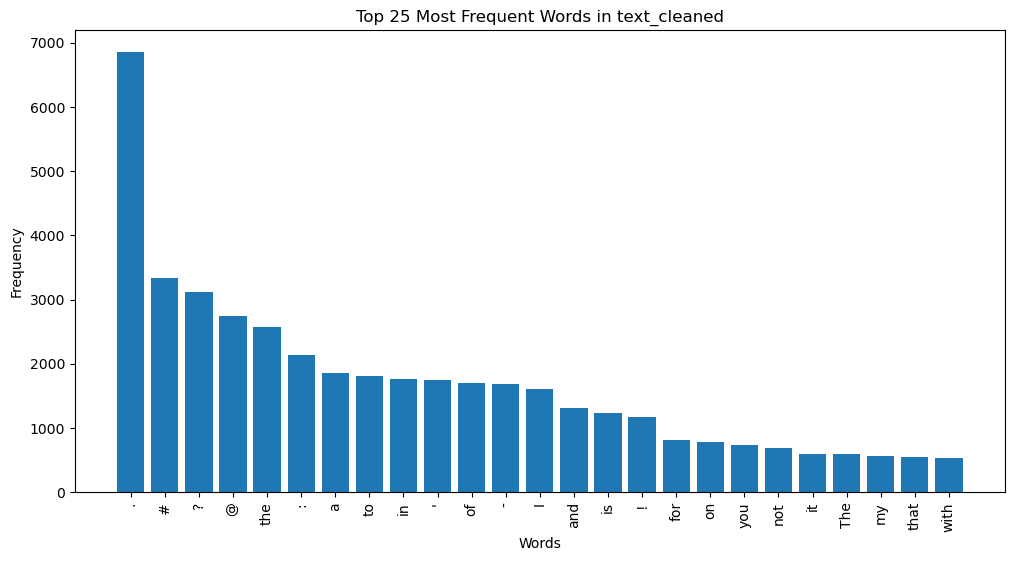

In [118]:
plot_word_frequency(train_df, 'text_cleaned', top_n=25)

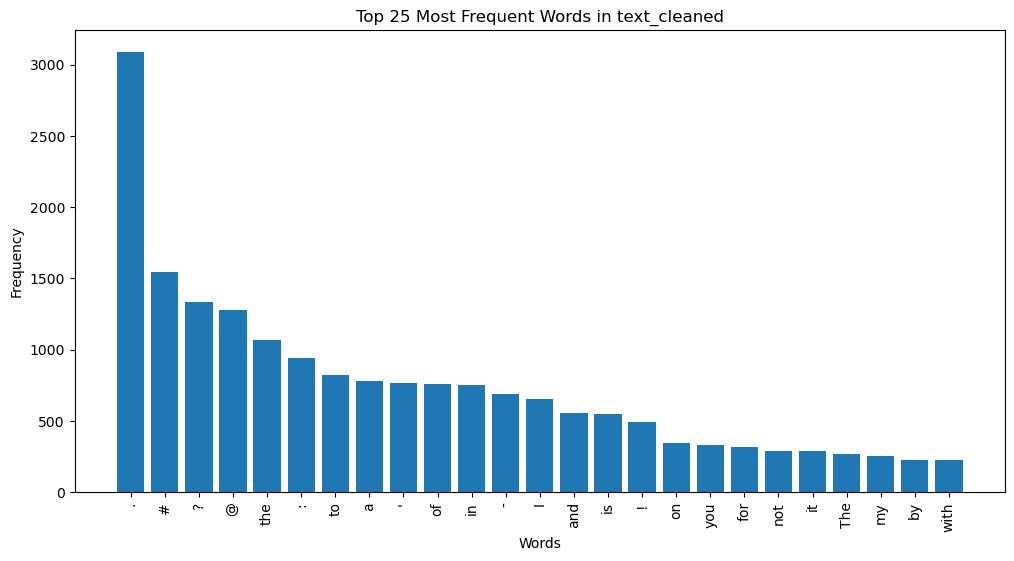

In [119]:
plot_word_frequency(test_df, 'text_cleaned', top_n=25)

## Summary of Cleaning
- In both training and testing dataset we ended up cleaning it up. Removing links, some special characters and uncommon unicode characters. 
- We did notice that the lenght of the tweets had a strong correlation with it coming from a news outlets or a more professional Twitter account. The shorter length tweets seem to come from people tweeting about what they see on their timeline. 
- Overall, I think cleaning up and preprocessing our data will help create a more accurate model.

## Spliting Datasets

In [120]:
X_train = train_df.drop(columns=['keyword', 'location', 'text', 'target', 'word_count',
                                 'unique_word_count', 'stop_word_count', 'url_count', 'mean_word_length',
                                 'char_count', 'punctuation_count', 'hashtag_count', 'mention_count',
                                 ])
y_train = train_df['target']

In [121]:
X_train.head()


,id,text_cleaned
0,1,Our Deeds are the Reason of this # earthquake...
1,4,Forest fire near La Ronge Sask . Canada
2,5,All residents asked to ' shelter in place ' ...
3,6,"13,000 people receive # wildfires evacuation ..."
4,7,Just got sent this photo from Ruby # Alaska a...


In [122]:
y_train.head()

0    1
1    1
2    1
3    1
4    1
Name: target, dtype: int8

In [123]:
X_train, X_validation, y_train, y_validation = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42)


In [1]:
from IPython import display


# Transformers
### Pretrained Bert Model

<img src="https://machinelearningmastery.com/wp-content/uploads/2021/08/attention_research_1-1090x1536.png" style="max-width:400px;">

# About the Archtecture

- The Encoder
    - Consist of a stack of $N=6$ identical layers where each layer is composed of 2 sublayers
    - The first sublayer implements a multi-head self attention mechanisim. It receives different linealry projected keys, and values to produce the h output. 
    - The second sublay is a fully connected FFN consisting of two linear transformations with ReLu.
    -  $\text{FFN}(x) = \text{ReLU}(\mathbf{W}_1 x + b_1) \mathbf{W}_2 + b_2$
    - The six layers of the Transfomer encoder apply the same linear transformations to all the words in the input sequence but each layer uses a different weights $(W_1, W_2)$ and bias $(b_1, b_2)$.
    - Each of the sublayers is succeeded by a normalization layer. 
- The Decoder
    - The decoder also consist of a stack of $ N=6$ identical layers that are each composed of 3 sublayers.
    - The $1st$ sublayer receives the previous output of the encoder stacks, augments it with positional information and implements multi-head self-attention over it. 
    - In the multi-head attention mechanism it introduces a mask over the values produced by a scaled multiplication of matrices Q and K. 
    - The $2nd$ layer implements a similar multi-head attention mechanism but on the decoder side it receives the queries from the previous decoder sublayer and the keys as well as the values. Which allows to attent to all the words in a the input sequence.
    - The $3rd$ layer is a FFN.
   

In [124]:
model_name="distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [125]:
train_data = pd.concat([X_train, y_train], axis=1)
val_data = pd.concat([X_validation, y_validation], axis=1)

In [126]:
train_dataset = Dataset.from_pandas(train_data)
val_dataset = Dataset.from_pandas(val_data)

train_dataset = train_dataset.remove_columns(['__index_level_0__'])
val_dataset = val_dataset.remove_columns(['__index_level_0__'])


In [127]:
dataset_dict = DatasetDict({"train": train_dataset, "val": val_dataset})


In [128]:
dataset_dict


DatasetDict({
    train: Dataset({
        features: ['id', 'text_cleaned', 'target'],
        num_rows: 6016
    })
    val: Dataset({
        features: ['id', 'text_cleaned', 'target'],
        num_rows: 1505
    })
})

In [129]:
dataset_dict.set_format("pandas")


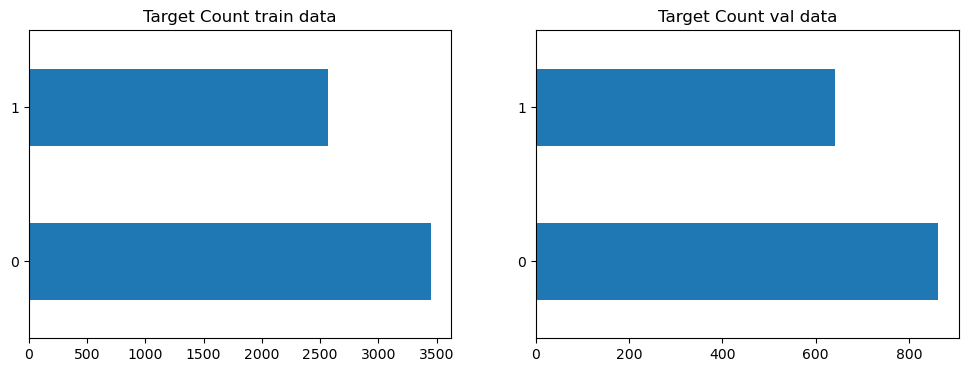

In [130]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
dataset_dict["train"]["target"].value_counts().plot.barh()
plt.title("Target Count train data")
plt.subplot(1, 2, 2)
dataset_dict["val"]["target"].value_counts().plot.barh()
plt.title("Target Count val data")
plt.show()


In [131]:
def tokenize_batch(batch):
    encodings = tokenizer(
        batch["text_cleaned"].tolist(),
        padding=True,
        return_tensors="tf",
    )
    
    batch_dict = {key: value.tolist() for key, value in batch.items() if key in ['id', 'target']}
    encodings_dict = {key: value.numpy().tolist() for key, value in encodings.items()}
    
    return {**batch_dict, **encodings_dict}

## Encoding Data

In [132]:
data_encoded = dataset_dict.map(tokenize_batch, batched=True, batch_size=None)


  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [133]:
data_encoded["train"][:].head()


,id,text_cleaned,target,input_ids,attention_mask
0,5602,survived the plague\nfloated the flood\njust p...,0,"[101, 5175, 1996, 11629, 13715, 1996, 7186, 20...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
1,7978,The Latest : More homes razed by Northern Cal...,1,"[101, 1996, 6745, 1024, 2062, 5014, 10958, 542...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
2,4972,GAElite 0 Explosion Greg 2 [ Top 3rd ] [...,1,"[101, 28151, 4221, 1014, 7738, 6754, 1016, 103...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
3,6631,@ Bilsko and suddenly I am inundated with res...,1,"[101, 1030, 12170, 4877, 3683, 1998, 3402, 104...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
4,8993,@ Coach_Keith44 @ HannoMottola @ TRPreston0...,0,"[101, 1030, 2873, 1035, 6766, 22932, 1030, 765...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."


In [134]:
data_encoded.set_format("tf")


# Model 1

In [135]:
class BertPretrainedForTweetClassification(tf.keras.Model):
    def __init__(self, model_name: str, num_classes: int):
        super().__init__()

        self.transformer = TFAutoModel.from_pretrained(model_name)
        self.dense = tf.keras.layers.Dense(512, activation="relu")
        self.dense2 = tf.keras.layers.Dense(32, activation="relu")
        self.dropout = tf.keras.layers.Dropout(0.4)
        self.output_layer = tf.keras.layers.Dense(
            num_classes, activation="sigmoid")

    def call(self, x):
        outputs = self.transformer(x)  # ["input_ids"], x["attention_mask"])
        cls_last_hidden = outputs.last_hidden_state[:, 0, :]
        x = self.dropout(cls_last_hidden)
        x = self.dense(x)
        x = self.dense2(x)
        x = self.output_layer(x)

        return x


In [136]:
def convert_to_tf_dataset(dataset):
    input_ids = dataset["input_ids"]
    attention_mask = dataset["attention_mask"]
    target = dataset["target"]
    return {"input_ids": input_ids, "attention_mask": attention_mask}, target

In [137]:
train_data_inputs = tf.data.Dataset.from_tensor_slices(convert_to_tf_dataset(data_encoded["train"]))
val_data_inputs = tf.data.Dataset.from_tensor_slices(convert_to_tf_dataset(data_encoded["val"]))

In [138]:
batch_size = 32
buffer_size = 500

train_data_inputs = train_data_inputs.shuffle(buffer_size).batch(batch_size)
val_data_inputs = val_data_inputs.batch(batch_size)

In [139]:
model = BertPretrainedForTweetClassification(model_name, 1)

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_layer_norm', 'activation_13', 'vocab_transform', 'vocab_projector']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


## EarlyStopping

In [140]:
# Define Callback functions
early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=2,
    verbose=1,
    restore_best_weights=True
)

class LearningRatePrinter(Callback):
    def on_epoch_begin(self, epoch, logs=None):
        lr = self.model.optimizer.learning_rate.numpy()
        print(f"Learning rate for epoch {epoch + 1}: {lr}")
        
lr_printer = LearningRatePrinter()

## Learning Rate

In [141]:
lr_schedule = ExponentialDecay(1e-5, len(train_dataset), 1e-4)

In [142]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=["accuracy"],
)

## Fit Model

In [143]:
history = model.fit(train_data_inputs,
          epochs=10,
          validation_data=val_data_inputs,
          callbacks=[early_stopping, lr_printer])

Learning rate for epoch 1: 9.999999747378752e-06
Epoch 1/10
188/188 [==============================] - 74s 284ms/step - loss: 0.4832 - accuracy: 0.7693 - val_loss: 0.4025 - val_accuracy: 0.8286
Learning rate for epoch 2: 7.510431714763399e-06
Epoch 2/10
188/188 [==============================] - 52s 274ms/step - loss: 0.3720 - accuracy: 0.8464 - val_loss: 0.3905 - val_accuracy: 0.8419
Learning rate for epoch 3: 5.632029115076875e-06
Epoch 3/10
188/188 [==============================] - 51s 270ms/step - loss: 0.3292 - accuracy: 0.8670 - val_loss: 0.3952 - val_accuracy: 0.8419
Learning rate for epoch 4: 4.2234260035911575e-06
Epoch 4/10
188/188 [==============================] - 51s 272ms/step - loss: 0.2987 - accuracy: 0.8881 - val_loss: 0.4275 - val_accuracy: 0.8279
Epoch 4: early stopping


# Metrics

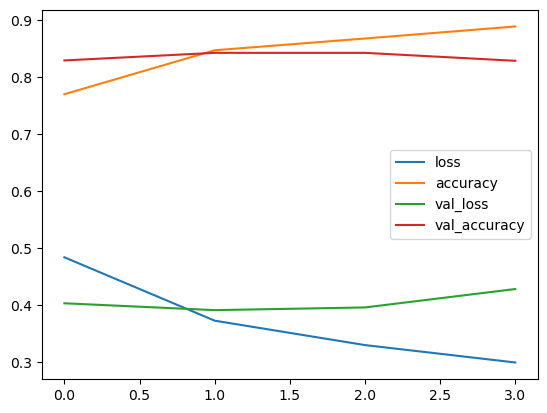

In [144]:
pd.DataFrame(history.history).plot();

# HyperParameter Tuning

In [145]:
def build_model(hp: HyperParameters):
    model_name = "distilbert-base-uncased"
    num_classes = 1

    model = BertPretrainedForTweetClassification(model_name, num_classes)

    # Hyperparameters
    lr = hp.Float("learning_rate", min_value=1e-5, max_value=1e-2, sampling="LOG")
    dropout_rate = hp.Float("dropout_rate", min_value=0.1, max_value=0.5, step=0.1)
    dense1_units = hp.Int("dense1_units", min_value=128, max_value=1024, step=128)
    dense2_units = hp.Int("dense2_units", min_value=16, max_value=256, step=16)

    model.dropout.rate = dropout_rate
    model.dense.units = dense1_units
    model.dense2.units = dense2_units

    # Learning rate schedule options
    learning_rate_option = hp.Choice("learning_rate_option", ["constant", "exponential"])

    if learning_rate_option == "exponential":
        decay_rate = hp.Float("decay_rate", min_value=0.8, max_value=0.99, step=0.01)
        lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
            lr, decay_steps=len(train_data_inputs) // batch_size, decay_rate=decay_rate
        )
    else:
        lr_schedule = lr

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
        loss=tf.keras.losses.BinaryCrossentropy(),
        metrics=["accuracy"],
    )

    return model

In [146]:
class CustomEarlyStopping(tf.keras.callbacks.Callback):
    def __init__(self, patience=0, min_delta=0, restore_best_weights=False):
        super().__init__()
        self.patience = patience
        self.min_delta = min_delta
        self.restore_best_weights = restore_best_weights
        self.wait = 0
        self.stopped_epoch = 0
        self.best_loss = float('inf')
        self.best_weights = None

    def on_epoch_end(self, epoch, logs=None):
        current_loss = logs.get('val_loss')
        if current_loss is None:
            return

        if current_loss < (self.best_loss - self.min_delta):
            self.best_loss = current_loss
            self.wait = 0
            if self.restore_best_weights:
                self.best_weights = self.model.get_weights()
        else:
            self.wait += 1
            if self.wait >= self.patience:
                self.stopped_epoch = epoch
                self.model.stop_training = True
                print(f"Epoch {epoch + 1}: early stopping")
                if self.restore_best_weights:
                    print("Restoring best weights")
                    self.model.set_weights(self.best_weights)

custom_early_stopping = CustomEarlyStopping(patience=2, restore_best_weights=True)

In [147]:
tuner = RandomSearch(
    build_model,
    objective="val_loss",
    max_trials=15,
    executions_per_trial=1,
    directory="tuner_results",
    project_name="tweet_classification_random_search",
)

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_layer_norm', 'activation_13', 'vocab_transform', 'vocab_projector']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


In [148]:
tuner.search(
    train_data_inputs,
    epochs=5,
    validation_data=val_data_inputs,
    callbacks=[custom_early_stopping]
)

In [149]:
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]
best_model = build_model(best_hp)

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_layer_norm', 'activation_13', 'vocab_transform', 'vocab_projector']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


# Model 2

In [150]:
def cross_validation(df=train_df, model_name="roberta-base", lr=lr_schedule, epochs=10, model=None, n_splits=5):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    # Create empty lists to store the performance metrics for each fold
    train_loss, train_acc, val_loss, val_acc = [], [], [], []
    histories = {}

    # Loop over each fold
    for i, (train_index, val_index) in enumerate(kf.split(df)):

        print(f"Fold {i+1}/{n_splits}")

        # Split the data into train and validation sets for this fold
        train_data = train_df.iloc[train_index]
        val_data = train_df.iloc[val_index]

        # Extract the X, y train/val
        train_data = train_data.drop(columns=["keyword", "location", "word_count"])

        val_data = val_data.drop(columns=["keyword", "location", "word_count"])

        # create huggingface datasets
        train_dataset = Dataset.from_pandas(train_data)
        val_dataset = Dataset.from_pandas(val_data)

        train_dataset = train_dataset.remove_columns(['__index_level_0__'])
        val_dataset = val_dataset.remove_columns(['__index_level_0__'])

        # create a dataset dict
        dataset_dict = DatasetDict({"train": train_dataset, "val": val_dataset})

        dataset_dict.set_format("pandas")

        data_encoded = dataset_dict.map(tokenize_batch, batched=True, batch_size=None)

        data_encoded.set_format("tf")
        
        if model is None:
            # create a model train and evaluate it on each batch
            model=BertPretrainedForTweetClassification(model_name, 1)
        else:
            model=model

        # Compile the model
        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
            loss=tf.keras.losses.BinaryCrossentropy(),
            metrics=["accuracy"],
        )

        # Train the model
        history = model.fit(train_data_inputs,
                  epochs=epochs,
                  validation_data=val_data_inputs,
                  callbacks=[early_stopping, lr_printer])

        histories[f"fold_{i}"] = history

        # Append the performance metrics to the lists for this fold
        train_loss.append(history.history['loss'])
        train_acc.append(history.history['accuracy'])
        val_loss.append(history.history['val_loss'])
        val_acc.append(history.history['val_accuracy'])

    # Calculate the average performance across all folds
    avg_train_loss = np.mean([h[-1] for h in train_loss])
    avg_train_acc = np.mean([h[-1] for h in train_acc])
    avg_val_loss = np.mean([h[-1] for h in val_loss])
    avg_val_acc = np.mean([h[-1] for h in val_acc])

    # Print the average performance metrics
    print(f"Average train loss: {avg_train_loss}")
    print(f"Average train accuracy: {avg_train_acc}")
    print(f"Average validation loss: {avg_val_loss}")
    print(f"Average validation accuracy: {avg_val_acc}")
    
    return histories

In [151]:
histories = cross_validation(model=best_model)

Fold 1/5


  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

Learning rate for epoch 1: 9.999999747378752e-06
Epoch 1/10
188/188 [==============================] - 77s 285ms/step - loss: 0.4945 - accuracy: 0.7751 - val_loss: 0.4037 - val_accuracy: 0.8332
Learning rate for epoch 2: 7.510431714763399e-06
Epoch 2/10
188/188 [==============================] - 51s 271ms/step - loss: 0.3699 - accuracy: 0.8511 - val_loss: 0.3997 - val_accuracy: 0.8392
Learning rate for epoch 3: 5.632029115076875e-06
Epoch 3/10
188/188 [==============================] - 51s 271ms/step - loss: 0.3305 - accuracy: 0.8703 - val_loss: 0.4106 - val_accuracy: 0.8399
Learning rate for epoch 4: 4.2234260035911575e-06
Epoch 4/10
188/188 [==============================] - 51s 272ms/step - loss: 0.2995 - accuracy: 0.8845 - val_loss: 0.4249 - val_accuracy: 0.8412
Epoch 4: early stopping
Fold 2/5


  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

Learning rate for epoch 1: 9.999999747378752e-06
Epoch 1/10
188/188 [==============================] - 74s 286ms/step - loss: 0.3388 - accuracy: 0.8677 - val_loss: 0.4282 - val_accuracy: 0.8332
Learning rate for epoch 2: 7.510431714763399e-06
Epoch 2/10
188/188 [==============================] - 51s 271ms/step - loss: 0.2960 - accuracy: 0.8915 - val_loss: 0.4311 - val_accuracy: 0.8399
Learning rate for epoch 3: 5.632029115076875e-06
Epoch 3/10
188/188 [==============================] - 51s 270ms/step - loss: 0.2563 - accuracy: 0.9048 - val_loss: 0.4602 - val_accuracy: 0.8339
Epoch 3: early stopping
Fold 3/5


  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

Learning rate for epoch 1: 9.999999747378752e-06
Epoch 1/10
188/188 [==============================] - 75s 285ms/step - loss: 0.2979 - accuracy: 0.8855 - val_loss: 0.4282 - val_accuracy: 0.8372
Learning rate for epoch 2: 7.510431714763399e-06
Epoch 2/10
188/188 [==============================] - 51s 269ms/step - loss: 0.2535 - accuracy: 0.9071 - val_loss: 0.4690 - val_accuracy: 0.8272
Learning rate for epoch 3: 5.632029115076875e-06
Epoch 3/10
188/188 [==============================] - 51s 271ms/step - loss: 0.2177 - accuracy: 0.9252 - val_loss: 0.5189 - val_accuracy: 0.8206
Epoch 3: early stopping
Fold 4/5


  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

Learning rate for epoch 1: 9.999999747378752e-06
Epoch 1/10
188/188 [==============================] - 74s 286ms/step - loss: 0.2603 - accuracy: 0.9046 - val_loss: 0.4743 - val_accuracy: 0.8292
Learning rate for epoch 2: 7.510431714763399e-06
Epoch 2/10
188/188 [==============================] - 51s 269ms/step - loss: 0.2142 - accuracy: 0.9267 - val_loss: 0.4966 - val_accuracy: 0.8292
Learning rate for epoch 3: 5.632029115076875e-06
Epoch 3/10
188/188 [==============================] - 51s 271ms/step - loss: 0.1908 - accuracy: 0.9340 - val_loss: 0.5681 - val_accuracy: 0.8186
Epoch 3: early stopping
Fold 5/5


  0%|          | 0/1 [00:30<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

Learning rate for epoch 1: 9.999999747378752e-06
Epoch 1/10
188/188 [==============================] - 75s 285ms/step - loss: 0.2284 - accuracy: 0.9205 - val_loss: 0.5026 - val_accuracy: 0.8213
Learning rate for epoch 2: 7.510431714763399e-06
Epoch 2/10
188/188 [==============================] - 51s 272ms/step - loss: 0.1854 - accuracy: 0.9370 - val_loss: 0.5603 - val_accuracy: 0.8159
Learning rate for epoch 3: 5.632029115076875e-06
Epoch 3/10
188/188 [==============================] - 51s 269ms/step - loss: 0.1582 - accuracy: 0.9471 - val_loss: 0.5814 - val_accuracy: 0.8179
Epoch 3: early stopping
Average train loss: 0.22450003623962403
Average train accuracy: 0.919115686416626
Average validation loss: 0.5106952309608459
Average validation accuracy: 0.8264451742172241


# Prediction

In [152]:
test_data = test_df[['id', 'text_cleaned']]
test_data.head()

,id,text_cleaned
0,0,Just happened a terrible car crash
1,2,"Heard about # earthquake is different cities,..."
2,3,"there is a forest fire at spot pond, geese are..."
3,9,Apocalypse lighting . # Spokane # wildfires
4,11,Typhoon Soudelor kills 28 in China and Taiwan


In [153]:
encoded_texts = tokenizer(
    list(test_data["text_cleaned"].values),
    padding=True,
    return_tensors="tf",
)

In [154]:
inputs = (
    encoded_texts["input_ids"],
    encoded_texts["attention_mask"],
)

In [155]:
probabilities = best_model.predict(inputs)

102/102 [==============================] - 9s 66ms/step


In [156]:
predictions = np.round(probabilities).astype(int)

In [157]:
test_data["target"] = predictions
test_data.head()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,id,text_cleaned,target
0,0,Just happened a terrible car crash,1
1,2,"Heard about # earthquake is different cities,...",1
2,3,"there is a forest fire at spot pond, geese are...",1
3,9,Apocalypse lighting . # Spokane # wildfires,1
4,11,Typhoon Soudelor kills 28 in China and Taiwan,1


In [158]:
final_output = test_data[["id", "target"]]
final_output.to_csv("submission.csv", index=False)

# Results & Conclusion

In this project I compared two different models with the same architectures that attempted to classify tweet as either `disaster` or `not disaster` respectively `1` and `0`. Both of my models used transformers but there was two different pretrained models used. The first pretrained model was a basic BERT model that is designed to pre-train deep bidrectional representations from unlabeled text by jointly conditioning on both left and right context in all layers. The highest accuarcy this model achieved was at `75%`. With hyperparameter tuning.
The second model used the same architecture but used a different pre-trained LLM that was trained on 7 billion Tweets from over 100 distinct languages. What makes this pre-trained model perfect for our problem is that not was it trained with text-based self-supervision but also with social objective based on the rich social engagments within Twitter Heterogenous Information Network. That model out performed our previous model by about 15%. Some of the numbers below will give you an understand of its performance. 

Average train loss: 0.22450003623962403
Average train accuracy: 0.919115686416626
Average validation loss: 0.5106952309608459

Overall, I think this was a good introduction to transformers as the industry seems to be implementing NLP modeling using this type of architecture. 

# References
- https://www.kaggle.com/code/gunesevitan/nlp-with-disaster-tweets-eda-cleaning-and-bert
- https://huggingface.co/Twitter/twhin-bert-base
- https://machinelearningmastery.com/the-transformer-model/